In [1]:
import sys
sys.path.append('..')
import edlib
import numpy as np
from collections import Counter, defaultdict
import operator
from string import ascii_uppercase
from itertools import groupby
from copy import deepcopy


from lrd_parser import LRD_Report
from utils.bio import hamming_distance, identity_shift, OverlapAlignment, compress_homopolymer
import networkx as nx

import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from ndex2.nice_cx_network import NiceCXNetwork
import ndex2.client as nc
import ndex2

%load_ext autoreload
%autoreload 2

# Read and correct gaps

In [2]:
lrd_report_fn = 'data/decomposition.tsv'
monomers_fn = "data/inferred_monomers_single.fa"

lrd_report = LRD_Report(lrd_report_fn=lrd_report_fn, monomers_fn=monomers_fn)

In [3]:
monomer_strings = {r_id: record.string for r_id, record in lrd_report.records.items()}
len(monomer_strings)

471

In [4]:
def filter_strings(monomer_strings, max_gap=0.05, max_lowercase=0.01):
    filtered_strings = {}
    for r_id, string in monomer_strings.items():
        ngaps = Counter(string)['=']
        lowercase = [s.islower() for s in string]
        if np.mean(lowercase) > max_lowercase:
            continue
        if ngaps / len(string) <= max_gap:
            filtered_strings[r_id] = string
    return filtered_strings

In [5]:
monomer_strings = filter_strings(monomer_strings)
len(monomer_strings)

407

In [6]:
def get_ma(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def trim_read(monomer_string, max_gap, ma_window):
    is_gap = [c == '=' for c in monomer_string]
    ma = get_ma(is_gap, N=ma_window)
    l = 0
    while l < len(ma) and ma[l] > max_gap:
        l += 1
    r = len(ma) - 1
    while r >= 0 and ma[r] > max_gap:
        r -= 1
    trimmed_read = monomer_string[l:r+1+ma_window]
    trimmed_read = trimmed_read.strip('=')
    return trimmed_read

def trim_reads(monomer_strings, max_gap=0.2, ma_window=30):
    trimmed_reads = {}
    for r_id, monomer_string in monomer_strings.items():
        trimmed_read = trim_read(monomer_string, max_gap=max_gap, ma_window=ma_window)
        trimmed_reads[r_id] = trimmed_read
    return trimmed_reads

In [7]:
monomer_strings = trim_reads(monomer_strings)
len(monomer_strings)

407

In [8]:
def get_frequent_kmers(strings, k, min_mult=5):
    all_kmers = Counter()
    read_kmer_locations = defaultdict(list)
    for r_id, string in strings.items():
        for i in range(len(string)-k+1):
            kmer = string[i:i+k]
            if '=' not in kmer:
                all_kmers[kmer] += 1
                read_kmer_locations[kmer].append((r_id, i))
                
    frequent_kmers = {kmer: cnt for kmer, cnt in all_kmers.items()
                      if cnt >= min_mult}
    frequent_kmers_read_pos = {kmer: read_kmer_locations[kmer] for kmer in frequent_kmers}
    return frequent_kmers, frequent_kmers_read_pos

In [9]:
class DeBruijnGraph:
    def __init__(self, k, max_uniq_cov=30):
        self.graph = nx.MultiDiGraph()
        self.k = k
        self.node_mapping = {}
        self.rev_node_mapping = {}
        self.max_uniq_cov = max_uniq_cov

    def add_kmer(self, kmer, coverage=1):
        prefix, suffix = kmer[:-1], kmer[1:]
        
        if prefix in self.node_mapping:
            prefix_node_ind = self.node_mapping[prefix]
        else:
            prefix_node_ind = len(self.node_mapping)
            self.node_mapping[prefix] = prefix_node_ind
            self.rev_node_mapping[prefix_node_ind] = prefix
        
        if suffix in self.node_mapping:
            suffix_node_ind = self.node_mapping[suffix]
        else:
            suffix_node_ind = len(self.node_mapping)
            self.node_mapping[suffix] = suffix_node_ind
            self.rev_node_mapping[suffix_node_ind] = suffix
        
        
        # self.graph.add_edge(prefix, suffix,
        self.graph.add_edge(prefix_node_ind, suffix_node_ind,
                            edge_kmer=kmer,
                            length=self.k,
                            coverages=[coverage],
                            label=f'len={self.k}\ncov={coverage}',
                            color='black' if coverage < self.max_uniq_cov else 'red')

    def add_kmers(self, kmers, coverage=None):
        for kmer in kmers:
            if coverage is None:
                self.add_kmer(kmer)
            else:
                self.add_kmer(kmer, coverage=coverage[kmer])
                
    def index_edges(self, min_k=2):
        all_index = {}
        for k in range(min_k, self.k+1):
            index = defaultdict(list)
            for e_ind, edge in enumerate(self.graph.edges(keys=True)):
                edge_seq = self.graph.get_edge_data(*edge)['edge_kmer']
                for i in range(len(edge_seq)-k+1):
                    kmer = edge_seq[i:i+k]
                    index[kmer].append((e_ind, i))
            index_unique = {kmer: pos[0]
                            for kmer, pos in index.items()
                            if len(pos) == 1}
            all_index[k] = index_unique
        return all_index
            
    def collapse_nonbranching_paths(self):
        def node_on_nonbranching_path(graph, node):
            return nx.number_of_nodes(graph) > 1 \
                and graph.in_degree(node) == 1 \
                and graph.out_degree(node) == 1

        for node in list(self.graph.nodes()):
            if node_on_nonbranching_path(self.graph, node):
                in_edge = list(self.graph.in_edges(node, keys=True))[0]
                out_edge = list(self.graph.out_edges(node, keys=True))[0]
                # in_edge_color = self.graph.edges[in_edge]['color']
                # out_edge_color = self.graph.edges[out_edge]['color']
                in_edge_kmer = self.graph.edges[in_edge]['edge_kmer']
                out_edge_kmer = self.graph.edges[out_edge]['edge_kmer']
                in_edge_cov = self.graph.edges[in_edge]['coverages']
                out_edge_cov = self.graph.edges[out_edge]['coverages']

                in_node = in_edge[0]
                out_node = out_edge[1]

                new_kmer = in_edge_kmer + \
                    out_edge_kmer[-(len(out_edge_kmer)-self.k+1):]
                new_coverages = in_edge_cov + out_edge_cov
                new_coverages.sort()
                new_edge_len = self.k+len(new_coverages)-1
                new_edge_mean_cov = np.mean(new_coverages)
                self.graph.add_edge(in_node, out_node,
                                    edge_kmer=new_kmer,
                                    coverages=new_coverages,
                                    length=new_edge_len,
                                    label=f'len={new_edge_len}\ncov={new_edge_mean_cov}',
                                    color='black' if new_edge_mean_cov < self.max_uniq_cov else 'red')
                self.graph.remove_node(node)

    def get_edges(self):
        self.collapse_nonbranching_paths()
        contigs, coverages = [], []
        for u, v, keys in self.graph.edges(data=True):
            contigs.append(keys['edge_kmer'])
            coverages.append(np.median(keys['coverages']))
        return contigs, coverages
    
    def get_path(self, list_edges):
        db_edges = list(self.graph.edges())
        path = ''
        path += self.graph.get_edge_data(*list_edges[0])['edge_kmer']
        for edge in list_edges[1:]:
            new_edge_seq = self.graph.get_edge_data(*edge)['edge_kmer']
            # print(len(path[-(self.k-1):]), path[-(self.k-1):])
            # print(len(new_edge_seq[:self.k-1]), new_edge_seq[:self.k-1])
            assert path[-(self.k-1):] == new_edge_seq[:self.k-1]
            path += new_edge_seq[self.k-1:]
        
        # process cycled path
        if list_edges[0][0] == list_edges[-1][1]:
            path = path[:-(self.k-1)]
            doubled_path = path*2
            min_shift, min_path = 0, path
            for i in range(1, len(path)):
                cur_path = doubled_path[i:i+len(path)]
                if cur_path < min_path:
                    min_shift = i
                    min_path = cur_path
            path = min_path
        return path
    
    def get_contigs(self):
        def get_valid_outpaths_from_edge(edge, taken_edges=set()):
            out_node = edge[1]
            out_degree_out_node = self.graph.out_degree(out_node)
            paths = [[edge]]
            if out_degree_out_node == 1:
                out_edge = list(self.graph.out_edges(out_node, keys=True))[0]
                if out_edge not in taken_edges:
                    passed_taken_edges = taken_edges.copy()
                    passed_taken_edges.add(edge)
                    paths = get_valid_outpaths_from_edge(out_edge,
                                                         taken_edges=passed_taken_edges)
                    paths = paths.copy()
                    for i in range(len(paths)):
                        paths[i].append(edge)
            
            return paths
        
        def get_valid_inpaths_from_edge(edge, taken_edges=set()):
            in_node = edge[0]
            in_degree_in_node = self.graph.in_degree(in_node)
            
            paths = [[edge]]
            if in_degree_in_node == 1:
                in_edge = list(self.graph.in_edges(in_node, keys=True))[0]
                if in_edge not in taken_edges:
                    passed_taken_edges = taken_edges.copy()
                    passed_taken_edges.add(edge)
                    paths = get_valid_inpaths_from_edge(in_edge,
                                                        taken_edges=passed_taken_edges)
                    paths = paths.copy()
                    for i in range(len(paths)):
                        paths[i].append(edge)
            return paths
        
        # Getting valid in- and out-paths for each edge
        edge_outpaths, edge_inpaths = {}, {}
        for edge in self.graph.edges(keys=True):
            edge_outpaths[edge] = get_valid_outpaths_from_edge(edge)
            edge_inpaths[edge] = get_valid_inpaths_from_edge(edge)
        for edge in self.graph.edges(keys=True):
            edge_inpaths[edge] = [tuple(path) for path in edge_inpaths[edge]]
            edge_outpaths[edge] = [tuple(path[::-1]) for path in edge_outpaths[edge]]
        
        # Unite all such paths and delete duplicates
        all_paths = []
        for edge in self.graph.edges(keys=True):
            all_paths += edge_inpaths[edge] + edge_outpaths[edge]
        all_paths = list(set(all_paths))
        
        # Select only paths that are not a subpath of other paths
        selected_paths = []
        # doubled_paths = [path + path for path in all_paths]
        for path1 in all_paths:
            has_duplicate = False
            for path2 in all_paths:
                if path1 == path2:
                    continue
                for i in range(len(path2)-len(path1)+1):
                    if path1 == path2[i:i+len(path1)]:
                        has_duplicate = True
                        break
                if has_duplicate:
                    break
            if not has_duplicate:
                selected_paths.append(path1)
        
        # check that all edges of that graph are incorporated in selected paths
        edges_in_selected_paths = []
        for path in selected_paths:
            edges_in_selected_paths += path
        # assert len(set(self.graph.edges(keys=True)) - set(edges_in_selected_paths)) == 0
        
        contigs = []
        for path in selected_paths:
            contigs.append(self.get_path(path))
        contigs = list(set(contigs))
        return contigs, selected_paths

In [10]:
frequent_kmers, frequent_kmers_read_pos = get_frequent_kmers(monomer_strings, k=3, min_mult=1000)
db = DeBruijnGraph(k=3)
db.add_kmers(frequent_kmers, coverage=frequent_kmers)

hors, _ = db.get_contigs()

def correct_gaps(monomer_strings, hors, max_gap=0.7, nhor=5):
    corrected_strings = {}
    for r_id, monomer_string in monomer_strings.items():
            corrected_string = list(monomer_string)
            for single_hor in hors:
                for i_nhor in range(1, nhor+1):
                    hor = single_hor * i_nhor
                    hor_len = len(hor)
                    for i in range(len(monomer_string)-hor_len+1):
                        kmer = monomer_string[i:i+hor_len]
                        gap_cnt = Counter(kmer)['=']
                        if gap_cnt == 0 or gap_cnt / hor_len > max_gap:
                            continue
                        hd, _ = hamming_distance(kmer, hor, match_char=set('='))
                        if hd == 0:
                            # print(hor)
                            # print(kmer)
                            # print("")
                            corrected_string[i:i+hor_len] = list(hor)
                        
            corrected_strings[r_id] = ''.join(corrected_string)
    return corrected_strings

monomer_strings = correct_gaps(monomer_strings, hors)

In [11]:
def get_ngaps(strings):
    ngaps = 0
    for r_id, string in strings.items():
        r_ngaps = Counter(string)['=']
        if r_ngaps >= 5:
            mstring = string.lower()
            mstring = mstring.replace('=', '|')
            # print(r_id)
            # print(mstring)
            # print("")
        ngaps += r_ngaps
    return ngaps


ngaps = get_ngaps(monomer_strings)
print(ngaps)

152


In [12]:
def get_read_coverage(frequent_kmers_read_pos, monomer_strings, k):
    coverage = {}
    for r_id, string in monomer_strings.items():
        coverage[r_id] = [0] * (len(string) + 1)
    for pairs in frequent_kmers_read_pos.values():
        for r_id, pos in pairs:
            coverage[r_id][pos] += 1
            coverage[r_id][pos+k] -= 1
    for r_id in coverage:
        coverage[r_id] = np.cumsum(coverage[r_id])
        coverage[r_id] = coverage[r_id][:-1]
    return coverage

def find_zero_cov(coverage):
    all_zero_cov = {}
    for r_id in coverage:
        zero_cov_flatten = np.where(coverage[r_id] == 0)[0]
        if len(zero_cov_flatten) == 0:
            all_zero_cov[r_id] = []
            continue
        zero_cov = []
        zero_cov.append([zero_cov_flatten[0]])
        for pos in zero_cov_flatten[1:]:
            if pos == zero_cov[-1][-1] + 1:
                zero_cov[-1].append(pos)
            else:
                zero_cov.append([pos])
        
        all_zero_cov[r_id] = [(x[0], x[-1]) for x in zero_cov]
        
    return all_zero_cov

def find_path_debr(zero_cov, read_seq, r_id, k, db,
                   max_len=1000, min_len=1, min_overlap=3, max_overlap=30, max_dist=1):
    k -= 1
    results = {}
    corrected_seq = list(read_seq)
    for st, en in zero_cov[::-1]:
        if st < k or en > len(read_seq) - 1 - k or en-st+1 > max_len or en-st+1 < min_len:
            # results[(st, en)] = '-'
            continue
        # print(r_id, st, en)
        st_kmer, en_kmer = read_seq[st-k:st], read_seq[en+1:en+1+k]
        # assert st_kmer in frequent_kmers
        # assert en_kmer in frequent_kmers
        # assert read_seq[st-k+1:st+1] not in frequent_kmers
        # assert read_seq[en:en+k] not in frequent_kmers
        # assert st_kmer in db.graph.nodes

        u = st_kmer
        kmers = [u]
        while u != en_kmer and len(kmers) < 2*k:
            u_node = db.node_mapping[u]
            out_edges = list(db.graph.out_edges(u_node))
            # print(list(db.graph.nodes(data=True))[0])
            # print(u, len(db.graph.in_edges(u_node)), len(out_edges))
            # print(out_edges)
            if len(out_edges) == 1:
                edge = out_edges[0]
                assert edge[0] == u_node
                u_node = edge[1]
                u = db.rev_node_mapping[u_node]
                kmers.append(u)
            else:
                break
            
        if len(kmers) < min_overlap + 1:
            # results[(st, en)] = '-'
            # print(kmers)
            continue

        # print(len(kmers))
        extension = [kmer[-1] for kmer in kmers[1:]]
        extension = ''.join(extension)
        read_segment = read_seq[en+1:en+len(extension)]
        # print(extension)
        # print(read_segment)
        
        ident = identity_shift(extension[:max_overlap],
                               read_segment[:max_overlap],
                               min_overlap=min_overlap,
                               match_char=set('='))
        # print(ident)
        if ident['id'] == 1 and ident['shift'] is not None:
            # print(ident)
            correction = extension[:ident['shift']]
            if abs(len(correction) - (en-st+1)) > 10:
                # results[(st, en)] = '-'
                continue
            print(read_seq[st:en+1], read_seq[st-5:en+6])
            print(correction, len(correction))
            print("")
            results[(st, en)] = (read_seq[st:en+1], correction)
            corrected_seq[st:en+1] = list(correction)
    corrected_seq = ''.join(corrected_seq)
    return results, corrected_seq


def correct_seq(monomer_strings, k, min_mult=10):
    frequent_kmers, frequent_kmers_read_pos = get_frequent_kmers(monomer_strings, k=k, min_mult=min_mult)
    db = DeBruijnGraph(k=k)
    db.add_kmers(frequent_kmers, coverage=frequent_kmers)
    coverage = get_read_coverage(frequent_kmers_read_pos=frequent_kmers_read_pos,
                                 monomer_strings=monomer_strings,
                                 k=k)
    zero_cov = find_zero_cov(coverage=coverage)
    
    all_corrections = {}
    corrected_seqs = {}
    for r_id in zero_cov:
        all_corrections[r_id], corrected_seqs[r_id] = find_path_debr(zero_cov[r_id],
                                                              monomer_strings[r_id],
                                                              r_id=r_id,
                                                              k=k,
                                                              db=db)
    return all_corrections, corrected_seqs


def correct_reads(monomer_strings, min_k=10, max_k=200, niter=1):
    corrected_seqs = monomer_strings
    for k in range(min_k, max_k):
        for i in range(niter):
            print(k, i)
            all_corrections, corrected_seqs = correct_seq(corrected_seqs, k=k)
            for r_id, corrections in all_corrections.items():
                if len(corrections):
                    print(r_id, corrections)
    return corrected_seqs

In [13]:
monomer_strings = correct_reads(monomer_strings)

10 0
== DEFGH==LMNOP
IJK 3

= NOPQL=NOPQR
M 1

B EFGHIBKLMNO
J 1

= BCGHI=KLMNO
J 1

== ADEFG==JKLMN
HI 2

= ADEFG=IJKLM
H 1

F BFGHIFKLMNO
J 1

C FGHIJCLMNOP
K 1

EFG= RABCGEFG=IJKLM
H 1

= QRADE=GHIJK
F 1

343a21b5-fd1f-486f-bf0f-5d4cabcda6e9 {(620, 621): ('==', 'IJK')}
42da64e4-e647-4426-b497-cda32cd3ca28 {(301, 301): ('=', 'M')}
46a4165e-6315-4339-9d4e-3af1ca00b3fc {(902, 902): ('B', 'J')}
647c3a75-dc83-414f-b342-6df41c7e59b7 {(398, 398): ('=', 'J')}
8e85dd90-8045-4df1-ba7b-b6b576deaa4d {(408, 409): ('==', 'HI')}
9e50bfee-7cce-4e72-9557-e40959c5fc51 {(29, 29): ('=', 'H')}
9ec8cb0b-c287-4823-9612-96befabdab60 {(84, 84): ('F', 'J')}
c210d178-68e0-4389-ad0a-5009d96c9d9c {(598, 598): ('C', 'K')}
c7e3bd82-2f61-4662-b255-ca9b66e20b95 {(130, 133): ('EFG=', 'H')}
f9474aed-548b-482b-a569-95d17bea44ba {(162, 162): ('=', 'F')}
10 1
11 0
11 1
12 0
=== DEFGH===MNOPQ
IJKL 4

= GHIJK=MNOPQ
L 1

= FGHIJ=MNOPQ
KL 2

H HIJKLHNOPQR
M 1

1d0706f6-cc39-4a05-a4fd-2ee7e1674457 {(452, 454): ('===', 'IJKL'

277 1
278 0
278 1
279 0
279 1
280 0
280 1
281 0
281 1
282 0
282 1
283 0
283 1
284 0
284 1
285 0
285 1
286 0
286 1
287 0
287 1
288 0
288 1
289 0
289 1
290 0
290 1
291 0
291 1
292 0
292 1
293 0
293 1
294 0
AB QRABCABFGHIJ
DE 2

ab3606e5-0041-4da0-9db5-6a30aedd8b83 {(603, 604): ('AB', 'DE')}
294 1
295 0
295 1
296 0
296 1
297 0
D QRABCDHIJKL
G 1

03e1fc3d-8e77-4170-94e1-3711db044f8b {(331, 331): ('D', 'G')}
297 1
298 0
298 1
299 0
299 1


In [14]:
ngaps = get_ngaps(monomer_strings)
print(ngaps)

104


# Iterative construction

In [15]:
def iterative_graph(monomer_strings, min_k, max_k, min_mult=5, step=1, starting_graph=None):
    dbs, all_contigs = {}, {}
    input_strings = monomer_strings.copy()
    
    if starting_graph is not None:
        contigs, contig_paths = starting_graph.get_contigs()
        for i in range(len(contigs)):
            for j in range(min_mult):
                input_strings[f'contig_k{min_k}_i{i}_j{j}'] = contigs[i]

    for k in range(min_k, max_k+1, step):
        print(f'\nk={k}')
        # print(len(input_strings))
        frequent_kmers, frequent_kmers_read_pos = get_frequent_kmers(input_strings, k=k, min_mult=min_mult)
        print(f'#frequent kmers = {len(frequent_kmers)}')
        db = DeBruijnGraph(k=k)
        db.add_kmers(frequent_kmers, coverage=frequent_kmers)

        # lens = sorted((len(contig), coverage) for contig, coverage in zip(contigs, coverages))[::-1]
        # long_edges = [x for x in lens if x[1] >= 50]
        db.collapse_nonbranching_paths()
        if nx.number_weakly_connected_components(db.graph) > 1:
            print(f'#cc = {nx.number_weakly_connected_components(db.graph)}')
            for cc in nx.weakly_connected_components(db.graph):
                print(len(cc))
            # break
        dbs[k] = db

        contigs, contig_paths = db.get_contigs()
        all_contigs[k] = contigs

        input_strings = monomer_strings.copy()
        # print(len(input_strings))
        for i in range(len(contigs)):
            for j in range(min_mult):
                input_strings[f'contig_k{k}_i{i}_j{j}'] = contigs[i]
        # print(len(input_strings))
    
    return all_contigs, dbs

In [16]:
min_k, max_k = 10, 634
contigs, dbs = iterative_graph(monomer_strings, min_k=min_k, max_k=max_k)


k=10
#frequent kmers = 97

k=11
#frequent kmers = 105

k=12
#frequent kmers = 113

k=13
#frequent kmers = 121

k=14
#frequent kmers = 129

k=15
#frequent kmers = 137

k=16
#frequent kmers = 148

k=17
#frequent kmers = 160

k=18
#frequent kmers = 175

k=19
#frequent kmers = 191

k=20
#frequent kmers = 206

k=21
#frequent kmers = 221

k=22
#frequent kmers = 236

k=23
#frequent kmers = 250

k=24
#frequent kmers = 263
#cc = 2
30
2

k=25
#frequent kmers = 276
#cc = 2
29
2

k=26
#frequent kmers = 289
#cc = 2
28
2

k=27
#frequent kmers = 302
#cc = 2
30
2

k=28
#frequent kmers = 314
#cc = 3
28
2
2

k=29
#frequent kmers = 326
#cc = 3
28
2
2

k=30
#frequent kmers = 338
#cc = 2
26
2

k=31
#frequent kmers = 351
#cc = 2
24
2

k=32
#frequent kmers = 365
#cc = 2
25
2

k=33
#frequent kmers = 378

k=34
#frequent kmers = 394

k=35
#frequent kmers = 411

k=36
#frequent kmers = 430

k=37
#frequent kmers = 449

k=38
#frequent kmers = 468

k=39
#frequent kmers = 487

k=40
#frequent kmers = 506

k=41
#frequ

#frequent kmers = 11994
#cc = 3
61
2
2

k=240
#frequent kmers = 12022
#cc = 3
61
2
2

k=241
#frequent kmers = 12050
#cc = 3
61
2
2

k=242
#frequent kmers = 12078
#cc = 3
61
2
2

k=243
#frequent kmers = 12106
#cc = 3
61
2
2

k=244
#frequent kmers = 12134
#cc = 3
53
2
2

k=245
#frequent kmers = 12159
#cc = 3
55
2
2

k=246
#frequent kmers = 12184
#cc = 3
54
2
2

k=247
#frequent kmers = 12208
#cc = 3
51
2
2

k=248
#frequent kmers = 12232
#cc = 3
51
2
2

k=249
#frequent kmers = 12256
#cc = 3
52
2
2

k=250
#frequent kmers = 12280
#cc = 3
52
2
2

k=251
#frequent kmers = 12304
#cc = 3
52
2
2

k=252
#frequent kmers = 12328
#cc = 3
52
2
2

k=253
#frequent kmers = 12352
#cc = 3
53
2
2

k=254
#frequent kmers = 12376
#cc = 3
53
2
2

k=255
#frequent kmers = 12400
#cc = 3
53
2
2

k=256
#frequent kmers = 12424
#cc = 3
53
2
2

k=257
#frequent kmers = 12448
#cc = 3
53
2
2

k=258
#frequent kmers = 12472
#cc = 3
53
2
2

k=259
#frequent kmers = 12496
#cc = 3
51
2
2

k=260
#frequent kmers = 12518
#cc = 3
49


k=459
#frequent kmers = 15441

k=460
#frequent kmers = 15453

k=461
#frequent kmers = 15465

k=462
#frequent kmers = 15477

k=463
#frequent kmers = 15489

k=464
#frequent kmers = 15500

k=465
#frequent kmers = 15511

k=466
#frequent kmers = 15522

k=467
#frequent kmers = 15533

k=468
#frequent kmers = 15544

k=469
#frequent kmers = 15555

k=470
#frequent kmers = 15566

k=471
#frequent kmers = 15577

k=472
#frequent kmers = 15588

k=473
#frequent kmers = 15599

k=474
#frequent kmers = 15610

k=475
#frequent kmers = 15621

k=476
#frequent kmers = 15632

k=477
#frequent kmers = 15643

k=478
#frequent kmers = 15654

k=479
#frequent kmers = 15664

k=480
#frequent kmers = 15674

k=481
#frequent kmers = 15684

k=482
#frequent kmers = 15694

k=483
#frequent kmers = 15704

k=484
#frequent kmers = 15714

k=485
#frequent kmers = 15724

k=486
#frequent kmers = 15734

k=487
#frequent kmers = 15744

k=488
#frequent kmers = 15754

k=489
#frequent kmers = 15764

k=490
#frequent kmers = 15774

k=491
#

In [20]:
# db = dbs[max(dbs.keys())]
db = dbs[634]
assert nx.number_weakly_connected_components(db.graph) == 1

In [21]:
contigs, contig_paths = db.get_contigs()

In [22]:
contig_lens = sorted(len(contig) for contig in contigs)
print(contig_lens)

[18, 648, 669, 669, 819, 991, 1264, 1591, 1591, 1685, 1867, 1897, 4564, 4582, 6336, 6354, 8295]


In [25]:
edges, coverage = db.get_edges()

In [26]:
edge_lens = sorted(len(edge) for edge in edges)
print(edge_lens)

[636, 637, 644, 658, 658, 658, 819, 934, 939, 991, 1251, 1269, 1566, 1685, 1899, 3932, 4452, 4476]


In [27]:
nx.drawing.nx_pydot.write_dot(db.graph, 'db.dot')

In [28]:
#nice_cx_debr_graph = ndex2.create_nice_cx_from_networkx(db.graph)

#nice_cx_debr_graph.upload_to(server='public.ndexbio.org', username = 'seryrzu',
#                             password = 'Kxoq)V?Z]vrgt87x*XO,:we)U&RwEEG!')

In [29]:
def map_reads(monomer_strings, db, db_index=None):
    if db_index is None:
        db_index = db.index_edges()
    mapping = {}
    db_edges = list(db.graph.edges(keys=True))
    for r_id, string in monomer_strings.items():
        split_strings = list(filter(lambda string: len(string), string.split('=')))
        split_lens = [0] + [len(split_string) for split_string in split_strings]
        cum_split_lens = np.cumsum(split_lens)
        read_coords = []
        for split_ind, split_string in enumerate(split_strings):
            for i in range(len(split_string)-db.k+1):
                kmer = split_string[i:i+db.k]
                if kmer in db_index[len(kmer)]:
                    read_coords.append(db_index[len(kmer)][kmer])
        
        path = [x[0] for x in read_coords]
        path = [x[0] for x in groupby(path)]
        path = [db_edges[edge_ind] for edge_ind in path]
        
        valid_path = True
        for e1, e2 in zip(path[:-1], path[1:]):
            if e1[1] != e2[0]:
                valid_path = False
                break
        if len(read_coords):
            mapping[r_id] = (read_coords[0], read_coords[-1], valid_path, path)
        else:
            mapping[r_id] = None
    return mapping

In [30]:
mappings = map_reads(monomer_strings, db)

In [33]:
print(np.mean([read_mapping is not None for read_mapping in mappings.values()]))
print(np.mean([read_mapping[2] for read_mapping in mappings.values() \
               if read_mapping is not None]))
print(np.sum([read_mapping[2] for read_mapping in mappings.values() \
               if read_mapping is not None]))

for r_id, read_mapping in mappings.items():
    if read_mapping is not None and read_mapping[2]:
        print(r_id, len(monomer_strings[r_id]), len(monomer_strings[r_id]) * 171,
              len(db.get_path(read_mapping[-1])), read_mapping)

0.7862407862407862
0.98125
314
00739941-c14c-40bd-9fad-fabff753795b 798 136458 1566 ((14, 299), (14, 463), True, [(10200, 6486, 0)])
01f80610-395e-4ef8-93d0-526989b8cb53 1214 207594 3932 ((10, 2210), (10, 2785), True, [(6831, 11344, 0)])
03e1fc3d-8e77-4170-94e1-3711db044f8b 658 112518 3932 ((10, 1011), (10, 1035), True, [(6831, 11344, 0)])
04b2f961-f6b4-438d-9a64-83dbd6049ffc 799 136629 4476 ((12, 3226), (12, 3391), True, [(8472, 4263, 0)])
050b88c4-e343-431d-99dc-4b8151b4adef 707 120897 4476 ((12, 1786), (12, 1859), True, [(8472, 4263, 0)])
0540aa3e-f34b-4e74-a5e5-884b69594a0d 641 109611 4476 ((12, 2870), (12, 2877), True, [(8472, 4263, 0)])
054f1983-9204-4889-936a-64ab45e7810c 701 119871 4452 ((1, 2770), (1, 2837), True, [(4263, 2694, 0)])
05a4fa6a-38b1-40d6-916e-886ad1fb050b 1032 176472 4452 ((1, 1078), (1, 1476), True, [(4263, 2694, 0)])
05c5a912-42ad-4a57-ae81-0a318dc8c6b7 865 147915 4452 ((1, 1867), (1, 2098), True, [(4263, 2694, 0)])
063b3d2c-c9b3-4292-861f-2839fc294b2b 642 1097

In [34]:
def filter_mappings(mappings, db):
    filtered_mappings = {}
    contigs, contig_paths = db.get_contigs()
    for r_id, read_mapping in mappings.items():
        if read_mapping is None or not read_mapping[-2]:
            continue
        read_mapping = read_mapping[-1]
        rm_len = len(read_mapping)
        if rm_len == 1:
            continue
        in_contig = False
        for path in contig_paths:
            path = list(path)
            for i in range(len(path)-rm_len+1):
                subpath = path[i:i+rm_len]
                # print(subpath)
                # print(read_mapping)
                if subpath == read_mapping:
                    in_contig = True
                    break
            if in_contig:
                break
        if not in_contig:
            filtered_mappings[r_id] = read_mapping
            # print(r_id, read_mapping)
        else:
            pass
            # print(r_id, read_mapping)
    return filtered_mappings

In [35]:
scaffolding_reads = filter_mappings(mappings, db)

In [36]:
len(scaffolding_reads)

31

In [37]:
def get_scaffold_links(scaffolding_reads, db):
    scaffolds = defaultdict(list)
    contigs, contig_paths = db.get_contigs()
    for r_id, scaffolding_read in scaffolding_reads.items():
        best_lo, best_lo_len, best_lo_shift = None, 0, 0
        best_ro, best_ro_len, best_ro_shift = None, 0, 0
        
        for i, path in enumerate(contig_paths):
            l_overlap = identity_shift(path, scaffolding_read, min_overlap=1)
            r_overlap = identity_shift(scaffolding_read, path, min_overlap=1)
            if l_overlap['id'] == 1 and len(l_overlap['alt_shifts']) == 0 \
                    and l_overlap['len'] >= best_lo_len \
                    and l_overlap['shift'] + len(scaffolding_read) > len(path) \
                    and l_overlap['shift'] >= 1:
                best_lo = list(path)
                best_lo_len = l_overlap['len']
                best_lo_shift = l_overlap['shift']
            
            if r_overlap['id'] == 1 and len(r_overlap['alt_shifts']) == 0 \
                    and r_overlap['len'] >= best_ro_len \
                    and r_overlap['shift'] + len(path) > len(scaffolding_read) \
                    and r_overlap['shift'] >= 1:
                best_ro = list(path)
                best_ro_len = r_overlap['len']
                best_ro_shift = r_overlap['shift']
            
        if best_lo is not None and best_ro is not None:
            scaffold = best_lo[:best_lo_shift] + scaffolding_read[:best_ro_shift] + best_ro
            scaffold = tuple(scaffold)
            scaffolds[scaffold].append(r_id)
#             print('left')
#             print(r_id)
#             print('read', scaffolding_read)
#             print('contig', best_lo)
#             print("")
#             print('right')
#             print(r_id)
#             print('read', scaffolding_read)
#             print('contig', best_ro)
#             print("")
#             print("scaffold:", scaffold)
#             print(len(db.get_path(scaffold)))
#             print("")
    
    return scaffolds
            

In [38]:
scaffolds = get_scaffold_links(scaffolding_reads, db)

In [41]:
for scaffold in scaffolds:
    print(scaffold, len(db.get_path(scaffold)))

((10200, 6486, 0), (6486, 6792, 0), (6792, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 6817, 0), (6817, 6828, 0), (6828, 6831, 0), (6831, 11344, 0), (11344, 9036, 0)) 6008
((6817, 6828, 0), (6828, 6831, 0), (6831, 11344, 0), (11344, 9036, 0), (9036, 4263, 0), (4263, 2694, 0)) 9667
((6817, 6828, 0), (6828, 6831, 0), (6831, 11344, 0), (11344, 9036, 1), (9036, 4263, 0), (4263, 2694, 0)) 9649


# Overlaps

In [92]:
def get_rare_mono_kmers(monomer_strings, k, min_mult=5, max_mult=15):
    all_kmers = Counter()
    kmer_locations = defaultdict(list)
    for r_id, string in monomer_strings.items():
        for i in range(len(string)-k+1):
            kmer = string[i:i+k]
            if '=' not in kmer:
                all_kmers[kmer] += 1
                kmer_locations[kmer].append((r_id, i))
                
    rare_kmers = {kmer: cnt for kmer, cnt in all_kmers.items()
                  if min_mult <= cnt <= max_mult}
    reads2rare_kmers = defaultdict(list)
    for kmer in rare_kmers:
        locs = kmer_locations[kmer]
        for loc in locs:
            r_id, coordinate = loc
            reads2rare_kmers[r_id].append(coordinate)
    for r_id in reads2rare_kmers:
        reads2rare_kmers[r_id].sort()
    return rare_kmers, reads2rare_kmers


def compute_overlap(s1, s2, kmer_coords1, kmer_coords2, k=200):
    kmers2pos1 = {s1[i:i+k]: i for i in kmer_coords1}
    kmers2pos2 = {s2[i:i+k]: i for i in kmer_coords2}
    #print(kmers2pos1)
    
    kmers_inters = set(kmers2pos1.keys()) & set(kmers2pos2.keys())
    
    kmers2pos1 = {kmer: kmers2pos1[kmer] for kmer in kmers_inters}
    kmers2pos2 = {kmer: kmers2pos2[kmer] for kmer in kmers_inters}
    
    kmers2pos1 = sorted(kmers2pos1.items(), key=operator.itemgetter(1))
    kmers2pos2 = [(kmer, kmers2pos2[kmer]) for kmer, pos in kmers2pos1]
    
    pos1 = [x[1] for x in kmers2pos1]
    pos2 = [x[1] for x in kmers2pos2]
    discordancy = [0, 0]
    for p11, p12, p21, p22 in zip(pos1[:-1], pos1[1:],
                                  pos2[:-1], pos2[1:]):
        d1 = p12 - p11
        d2 = p22 - p21
        #print(p11, p21, d1, d2)
        if d1 != d2:
            discordancy[0] += 1
            discordancy[1] += d2 - d1
    
    fkmer_p1 = pos1[0] if len(pos1) else None
    fkmer_p2 = pos2[0] if len(pos2) else None
    return len(kmers_inters), discordancy, fkmer_p1, fkmer_p2

    
def get_overlaps(monomer_strings, reads2rare_kmers,
                 min_overlap_kmers=10,
                 max_discordant_pos=0,
                 min_ident=0.99,
                 min_overlap_len=300):
    overlaps = defaultdict(lambda: defaultdict(list))
    for r_id1 in monomer_strings:
        overlaps[r_id1]
        for r_id2 in monomer_strings:
            if r_id1 >= r_id2:
                continue
            s1 = monomer_strings[r_id1]
            s2 = monomer_strings[r_id2]
            overlap = compute_overlap(s1=s1, s2=s2,
                                      kmer_coords1=reads2rare_kmers[r_id1],
                                      kmer_coords2=reads2rare_kmers[r_id2])
            overlap_len, discordancy, fkmer_p1, fkmer_p2 = overlap
            if overlap_len >= min_overlap_kmers and discordancy[0] <= max_discordant_pos:
                shift = fkmer_p1 - fkmer_p2
                if shift >= 0:
                    hd = hamming_distance(s1[shift:], s2, match_char='=')
                    ident = 1 - hd[0] / hd[1]
                    if ident >= min_ident and hd[1] >= min_overlap_len:
                        # print(overlap, hd, ident)
                        overlaps[r_id1][r_id2] = (overlap_len, ident, hd[1], shift)
                else:
                    shift=-shift
                    hd = hamming_distance(s2[shift:], s1, match_char='=')
                    ident = 1 - hd[0] / hd[1]
                    if ident >= min_ident and hd[1] >= min_overlap_len:
                        # print(overlap, hd, ident)
                        overlaps[r_id2][r_id1] = (overlap_len, ident, hd[1], shift)
    return overlaps


class OverlapGraph:
    def __init__(self, overlaps):
        self.graph = nx.DiGraph()
        for r_id1 in overlaps:
            for r_id2 in overlaps[r_id1]:
                kmer_overlap, ident, overlap_len, shift = overlaps[r_id1][r_id2]
                self.graph.add_edge(r_id1, r_id2, weight=overlap_len, shift=shift)


class MonomerContig:
    def __init__(self):
        self.max_pos = 0
        self.monomers = defaultdict(Counter)
        self.read_positions = {}
        self.coverage = defaultdict(int)
        self.string = ''

    def update_max_pos(self):
        if len(self.monomers):
            self.max_pos = max(self.monomers.keys())
        else:
            self.max_pos = 0
    
    def update_string(self):
        new_string = [0] * (self.max_pos + 1)
        for i, monomer_distr in self.monomers.items():
            new_string[i] = max(monomer_distr.items(),
                                key=operator.itemgetter(1))[0]
        self.string = ''.join(new_string)
    
    def get_string(self):
        self.update_string()
        return self.string

    def add_read(self, r_id, monomer_string, position):
        self.read_positions[r_id] = position
        new_freq_kmers = []
        for i, monomer in enumerate(monomer_string):
            # print(self.monomers[i+position][monomer])
            self.coverage[i + position] += 1
            self.monomers[i + position][monomer] += 1
            # print(self.monomers[i+position][monomer])
            
        self.update_max_pos()
        self.update_string()
        # assert len(set(new_freq_kmers)) == len(new_freq_kmers)

    def get_score(self, monomer_string, position):
        upper_lim = min(self.max_pos + 1, position + len(monomer_string))
        pos_scores = []
        for i in range(position, upper_lim):
            monomer = monomer_string[i-position]
            cloud_monomers = self.monomers[i]
            pos_score = cloud_monomers[monomer] / sum(cloud_monomers.values())
            pos_scores.append(pos_score)
        score = sum(pos_scores)# / len(pos_scores)
        return score
    

def get_heaviest_path(graph, monomer_strings):
    gr = graph.graph
    assert nx.is_directed_acyclic_graph(gr)
    
    weights = defaultdict(MonomerContig)
    for v in nx.topological_sort(gr):
        monomer_string = monomer_strings[v]
        if len(gr.in_edges(v)) == 0:
            weights[v].add_read(r_id=v, monomer_string=monomer_string, position=0)
        else:
            best_score, best_contig, best_pos = 0, None, None
            for edge in gr.in_edges(v):
                assert edge[1] == v
                u = edge[0]
                contig = weights[u]
                pos = contig.read_positions[u] + gr.edges[edge]['shift']
                score = contig.get_score(monomer_string=monomer_string, position=pos)
                if score > best_score:
                    best_score = score
                    best_contig = contig
                    best_pos = pos
            weights[v] = deepcopy(best_contig)
            weights[v].add_read(v, monomer_string, position=best_pos)
    return weights


def get_longest_contig(weights, graph):
    best_r_id = []
    for cc in nx.weakly_connected_components(graph.graph):
        cc_best_r_id, cc_best_len = None, 0 
        for r_id in cc:
            contig = weights[r_id]
            if len(contig.read_positions) > cc_best_len:
                cc_best_r_id = r_id
                cc_best_len = len(contig.read_positions)
        best_r_id.append(cc_best_r_id)
    return best_r_id

In [238]:
rare_kmers, reads2rare_kmers = get_rare_mono_kmers(monomer_strings, k=250)
overlaps = get_overlaps(monomer_strings, reads2rare_kmers, min_overlap_kmers=5, min_ident=0.99, min_overlap_len=250)



In [239]:
for r_id1 in overlaps:
    for r_id2 in overlaps[r_id1]:
        overlap = overlaps[r_id1][r_id2]
        if overlap[0] > 0:
            print(r_id1, r_id2, overlap)

00739941-c14c-40bd-9fad-fabff753795b 1f4000ef-a7d9-41ee-9c93-047ca36ae7d8 (20, 1.0, 544, 254)
00739941-c14c-40bd-9fad-fabff753795b 8f633f5b-eb70-4ab0-94d2-77c708561492 (157, 0.9970544918998527, 679, 59)
00739941-c14c-40bd-9fad-fabff753795b df436222-50d1-4975-861e-58ab06750067 (74, 1.0, 598, 200)
00739941-c14c-40bd-9fad-fabff753795b df9e6b8f-e94b-4bac-a69e-9e98b1769c42 (117, 1.0, 641, 157)
35e23dc0-4219-4951-b491-be041f325bf3 00739941-c14c-40bd-9fad-fabff753795b (162, 1.0, 556, 424)
35e23dc0-4219-4951-b491-be041f325bf3 6e54ff5e-7a55-4dad-bae3-004d255dddbd (162, 1.0, 665, 315)
35e23dc0-4219-4951-b491-be041f325bf3 7e9301cd-6184-44f7-9db4-849ac08d33a5 (46, 1.0, 638, 173)
35e23dc0-4219-4951-b491-be041f325bf3 8e85dd90-8045-4df1-ba7b-b6b576deaa4d (162, 1.0, 573, 407)
35e23dc0-4219-4951-b491-be041f325bf3 8f633f5b-eb70-4ab0-94d2-77c708561492 (137, 0.9959758551307847, 497, 483)
35e23dc0-4219-4951-b491-be041f325bf3 a7a6eb6b-2225-4396-bb6b-2c0809993922 (162, 1.0, 772, 208)
35e23dc0-4219-4951-b491-

8c2fad5b-b459-4519-87a5-b83bf372e3db 5b24ad34-47a7-44a3-999a-f2e3d539d7dc (79, 1.0, 614, 4)
8c2fad5b-b459-4519-87a5-b83bf372e3db 75d67010-b675-4529-bee0-70051c4009e5 (41, 1.0, 538, 156)
8c2fad5b-b459-4519-87a5-b83bf372e3db 7aeafbcb-6498-4d7b-92b7-20351a352c58 (11, 1.0, 497, 197)
92d8c15f-7fea-4944-bf7f-397e0ac6ae05 05a4fa6a-38b1-40d6-916e-886ad1fb050b (16, 0.9971988795518207, 357, 259)
92d8c15f-7fea-4944-bf7f-397e0ac6ae05 2150aca2-413b-4207-ab2d-ac2f390a625d (166, 0.9983136593591906, 593, 23)
92d8c15f-7fea-4944-bf7f-397e0ac6ae05 5b24ad34-47a7-44a3-999a-f2e3d539d7dc (39, 0.9976190476190476, 420, 196)
92d8c15f-7fea-4944-bf7f-397e0ac6ae05 814fadd3-b302-42f2-b650-d53315b7844e (156, 0.9982788296041308, 581, 35)
92d8c15f-7fea-4944-bf7f-397e0ac6ae05 8c2fad5b-b459-4519-87a5-b83bf372e3db (45, 0.9976415094339622, 424, 192)
92d8c15f-7fea-4944-bf7f-397e0ac6ae05 a61180df-982c-4d59-b8b3-eedad055ac2e (82, 0.9978308026030369, 461, 155)
92d8c15f-7fea-4944-bf7f-397e0ac6ae05 e7f9d7d2-9144-4693-b36e-e5c7e

e3179d89-15c3-48e3-b4a0-5572b29e8209 11f3f86e-7a31-466c-a78e-f2d96995b70c (267, 1.0, 600, 578)
e3179d89-15c3-48e3-b4a0-5572b29e8209 5bbd17b6-5345-4e42-8242-6c34ae8e9f8c (178, 1.0, 711, 55)
e3179d89-15c3-48e3-b4a0-5572b29e8209 6cab947f-d34f-4290-a06f-56de0f833f5b (182, 1.0, 607, 663)
e3179d89-15c3-48e3-b4a0-5572b29e8209 7bc276f0-1b37-442c-83b8-ba0f8cba3770 (375, 1.0, 645, 452)
e3179d89-15c3-48e3-b4a0-5572b29e8209 7c28cc24-1d36-456f-a02c-bef0849fbf2a (13, 1.0, 438, 832)
e3179d89-15c3-48e3-b4a0-5572b29e8209 83a800ae-fe30-456c-b2d4-63aea374b2f1 (499, 1.0, 936, 334)
e3179d89-15c3-48e3-b4a0-5572b29e8209 86fdd7a8-71b5-46fa-90d2-5e6888ae2289 (53, 1.0, 478, 792)
e3179d89-15c3-48e3-b4a0-5572b29e8209 97d968c4-3f16-4c6e-acb2-f79f092e9ab3 (429, 1.0, 866, 404)
e3179d89-15c3-48e3-b4a0-5572b29e8209 ea8138e6-df5a-4f84-aff5-5d1cb8ca5ed1 (506, 1.0, 1268, 2)
e3179d89-15c3-48e3-b4a0-5572b29e8209 ef4ebd93-5865-40ca-b218-3c101b593717 (213, 1.0, 728, 73)
e3179d89-15c3-48e3-b4a0-5572b29e8209 f1ec24ef-7cbc-4242

7961926d-fd27-4842-9c67-65050f1f6aaf e300ffe2-45b9-4858-82cf-aedf292f9191 (197, 1.0, 639, 291)
7961926d-fd27-4842-9c67-65050f1f6aaf ee709491-ebdf-4e40-b4ab-4f79c3f39ec2 (197, 1.0, 549, 381)
7961926d-fd27-4842-9c67-65050f1f6aaf efca4ba3-97ea-4f08-bfc9-a6f043685167 (151, 1.0, 400, 530)
7961926d-fd27-4842-9c67-65050f1f6aaf faaa25a5-d105-4e2f-80c0-c79c0f3bea3d (148, 1.0, 397, 533)
bb86c2bb-d507-4d7f-bf85-c1ae261e7e52 356056be-00d7-4e1a-b6d5-7a0865f3aefe (22, 0.9928057553956835, 556, 451)
bb86c2bb-d507-4d7f-bf85-c1ae261e7e52 3ca418ed-c4eb-4ae3-b52b-48a6df3b1d75 (118, 1.0, 651, 307)
bb86c2bb-d507-4d7f-bf85-c1ae261e7e52 805dd6c7-fb61-484c-a665-287de030251c (107, 1.0, 681, 207)
bb86c2bb-d507-4d7f-bf85-c1ae261e7e52 8d782575-f417-4185-898f-d9ed268f9e09 (107, 0.9974025974025974, 770, 114)
bb86c2bb-d507-4d7f-bf85-c1ae261e7e52 8e82bf8e-7a0c-4f8b-8f78-c80abf0f995f (105, 1.0, 669, 248)
bb86c2bb-d507-4d7f-bf85-c1ae261e7e52 c5bb3e14-3a0b-41f2-9b0f-2007cd12591f (99, 1.0, 604, 403)
bb86c2bb-d507-4d7f-bf8

In [240]:
graph = OverlapGraph(overlaps)
nx.number_weakly_connected_components(graph.graph)

3

In [241]:
for cc in nx.weakly_connected_components(graph.graph):
    print(len(cc), nx.is_directed_acyclic_graph(graph.graph.subgraph(cc)))

19 True
189 True
98 True


In [242]:
weights = get_heaviest_path(graph, monomer_strings)

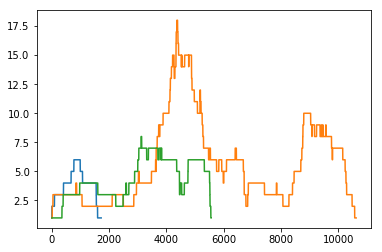

In [243]:
contigs = []
for r_id in get_longest_contig(weights, graph):
    longest_contig_cov = weights[r_id].coverage
    contig = weights[r_id].string
    contigs.append(contig)
    plt.plot(longest_contig_cov.keys(), longest_contig_cov.values())

# Comparison 2 K assembly

In [244]:
from string import ascii_uppercase

In [245]:
man_assembly_fn = "CEN6_ManVERSION3.tsv"

units = []
with open(man_assembly_fn) as f:
    for line in f:
        line = line.strip().split('\t')
        st, en = int(line[-2]), int(line[-1])
        if en < 17:
            en -= 1
        units.append((st, en))

In [246]:
def units2monomers(units):
    monomers = []
    for (s, e) in units:
        monomers.append(ascii_uppercase[s:e+1])
    monomers = ''.join(monomers)
    return monomers

In [247]:
ref_monomers = units2monomers(units)

In [252]:
def get_cov(ref_monomers, seqs, max_ed=10000):
    coverage = [0] * (len(ref_monomers)+1)
    for r_id, seq in seqs.items():
        alignment = edlib.align(seq,
                                ref_monomers,
                                mode='HW',
                                task='locations',
                                k=max_ed)
        print(alignment, np.diff(alignment['locations']))
        loc = alignment['locations']
        if loc is None or len(loc) != 1:
            continue
        else:
            loc = loc[0]
        coverage[loc[0]] += 1
        coverage[loc[1]+1] -= 1
    coverage = np.cumsum(coverage)
    return coverage

In [253]:
ref_coverage = get_cov(ref_monomers, {i: contig for i, contig in enumerate(contigs)})

{'editDistance': 36, 'alphabetLength': 19, 'locations': [(0, 1693)], 'cigar': None} [[1693]]
{'editDistance': 90, 'alphabetLength': 18, 'locations': [(810, 11507)], 'cigar': None} [[10697]]
{'editDistance': 21, 'alphabetLength': 19, 'locations': [(12201, 17751)], 'cigar': None} [[5550]]


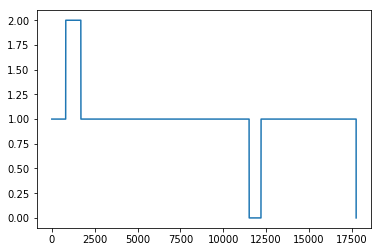

In [250]:
plt.plot(ref_coverage)

In [251]:
[len(contig) for contig in contigs]

[1726, 10627, 5563]